<b>Author:</b> Jhosimar George Arias Figueroa

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

### Load MNIST dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
num_samples = mnist.train.num_examples
num_features = mnist.train.images.shape[1]
print("Number of Samples: {}. Feature Dimension: {}".format(num_samples, num_features))

Number of Samples: 55000. Feature Dimension: 784


### Data Visualization

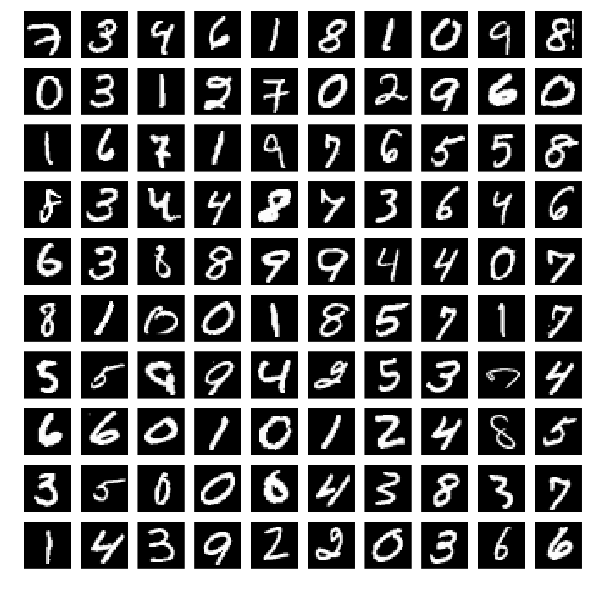

In [4]:
plt.figure(figsize=[10,10])
for i in range(0,100):
    plt.subplot(10,10,i+1)
    plt.imshow(np.reshape(mnist.train.images[i], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')

### Model Implementation

In [5]:
### Auxiliary Methods for Network Creation
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

In [6]:
class ConditionalVAE:
    
    def __init__(self, **options):
        self.latent_dim = options.get("latent_dim",20)           # latent space dimension (z)
        self.batch_size = options.get("batch_size", 200)         # training batch size
        self.epochs = options.get("epochs", 100)                 # number of training epochs
        self.learning_rate = options.get("learning_rate", 0.01)  # learning rate
        self.sess = tf.Session()                                 # tensorflow session
        self.display_step = options.get("display_step", 1)       # display loss
    
    # Encoder (inference model q, variational approximation for posterior p(z|x)) 
    # input: data (num_samples x num_features), label (num_samples x num_categories)
    # output: parameters for mean and standard deviation
    def encoder(self, X, y):
        
        with tf.variable_scope("encoder"):
            xy = tf.concat(1, (X, y))
            
            #hidden layer 1
            W1 = weight_variable([self.num_features + self.num_categories, 500])
            b1 = bias_variable([500])
            h1 = tf.nn.tanh(tf.matmul(xy, W1) + b1)
            
            #hidden layer 2
            W2 = weight_variable([500, 250])
            b2 = bias_variable([250])
            h2 = tf.nn.tanh(tf.matmul(h1,W2) + b2)
            
            #mean layer
            W_mean = weight_variable([250, self.latent_dim])
            b_mean = bias_variable([self.latent_dim])
            h_mean = tf.matmul(h2, W_mean) + b_mean
            
            #variance layer
            W_logVar = weight_variable([250, self.latent_dim])
            b_logVar = bias_variable([self.latent_dim])
            h_logVar = tf.matmul(h2,W_logVar) + b_logVar
            
        return h_mean, h_logVar
    
    # Decoder (generative model p)
    # input: latent space (num_samples x latent_dim), labels (num_samples x num_categories)
    # output: reconstruction of initial data X
    def decoder(self, z_latent, y):
        with tf.variable_scope("decoder"):
            zy = tf.concat(1, (z_latent, y))
            
            #hidden layer 1
            W_latent = weight_variable([self.latent_dim + self.num_categories, 250])
            b_latent = bias_variable([250])
            h_latent = tf.nn.tanh(tf.matmul(zy , W_latent) + b_latent )
            
            #hidden layer 2
            W2 = weight_variable([250, 500])
            b2 = bias_variable([500])
            h2 = tf.nn.tanh(tf.matmul(h_latent, W2) + b2)
            
            #reconstruction layer
            W1 = weight_variable([500, self.num_features])
            b1 = bias_variable([self.num_features])
            X = tf.nn.sigmoid(tf.matmul(h2, W1) + b1)
            
        return X
    
    # Reparametrization trick 
    # N(z; μ, σI) = μ + σε
    def gaussian_latent_space(self, mean, logVar):
        noise = tf.random_normal(tf.shape(mean), mean = 0 , stddev = 1, dtype= tf.float32)
        z = mean + tf.sqrt(tf.exp(logVar)) * noise
        return z
    
    # cross_entropy(t,o) = -(t * log(o) + (1-t) * log(1-o)) 
    @staticmethod
    def binary_cross_entropy(x, x_reconstructed, offset = 1e-8):
        return -tf.reduce_sum( x * tf.log( offset + x_reconstructed ) + 
                              (1 - x) * tf.log( offset + 1 - x_reconstructed ) , 1)
    
    # divergence = -1/2 * sum( 1 + log(sigma^2) - sigma^2 - mean^2 )
    @staticmethod
    def KL_divergence(mean, logVar):
        return -0.5 * tf.reduce_sum(1 + logVar - 
                                    tf.exp(logVar) - tf.square(mean), 1 ) 
    
    def train(self, data, labels):
        self.num_features = data.shape[1]
        self.num_samples = data.shape[0]
        self.num_categories = labels.shape[1]
        
        self.X = tf.placeholder(tf.float32, [None, self.num_features])
        self.y = tf.placeholder(tf.float32, [None, self.num_categories])
        
        # Calculate mean and std from input data
        z_mean, z_logVar = self.encoder(self.X, self.y)
        
        # Create gaussian sampler z
        self.z_latent = self.gaussian_latent_space(z_mean, z_logVar)
        
        # Reconstruct data from latent sample z
        self.reconstructed = self.decoder(self.z_latent, self.y)
        
        # Loss = Reconstruction loss + KL-divergence cost
        divergence_loss = self.KL_divergence(z_mean, z_logVar)
        reconstruction_loss = self.binary_cross_entropy(self.X, self.reconstructed)
        total_loss = tf.reduce_mean(reconstruction_loss + divergence_loss)
        
        # Optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(total_loss)
        
        # Variable initialization
        self.sess.run(tf.initialize_all_variables())
        num_batches = int(self.num_samples/self.batch_size)
        
        self.saver = tf.train.Saver()                            # save model after training
        
        # Number of iterations
        for epoch in range(self.epochs):
            avg_loss = 0
            avg_divergence = 0
            avg_reconstruction = 0
            
            # Iterate on each batch
            for i in range(num_batches):
                start = i * self.batch_size
                end = i * self.batch_size + self.batch_size
                # Get current batch
                batch_X = data[start:end][:]
                batch_y = labels[start:end][:]
                
                # Train VAE and get current losses
                _, kl_loss, rec_loss, tot_loss = self.sess.run( (optimizer, divergence_loss, 
                                                                 reconstruction_loss, total_loss), 
                                                                 feed_dict={self.X : batch_X, self.y: batch_y} )
                avg_divergence += np.mean( kl_loss )
                avg_reconstruction += np.mean( rec_loss )
                avg_loss += tot_loss
            
            avg_reconstruction /= num_batches
            avg_divergence /= num_batches
            avg_loss /= num_batches
            
            if( epoch % self.display_step == 0 ):
                #print("Epoch:", '%04d' % (epoch+1),
                #      "Divergence={:.6f}, Reconstruction={:.6f}, Loss={:.6f}".format(epoch + 1, avg_divergence, 
                                                                                #avg_reconstruction, avg_loss)) 
                print("Epoch {}: -- Divergence={}, Reconstruction={}, Loss={}".format(epoch + 1, avg_divergence, 
                                                                                avg_reconstruction, avg_loss))

    # Visualize generated sample
    # input: label (int or one-hot:1xnum_categories), noise (n x latent_dim)
    def visualize_generation(self, label, noise = None):
        if( noise == None ):
            noise = np.random.normal(0, 1 , [1, self.latent_dim])
            
        if( isinstance( label, int ) ):
            #convert label to one hot
            one_hot = np.eye(self.num_categories)[label].reshape(1,self.num_categories).astype(noise.dtype)
        else:
            one_hot = label
            
        x_generated = self.sess.run(self.reconstructed, feed_dict={self.z_latent: noise, self.y: one_hot})
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(x_generated.reshape(28, 28), vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
        plt.axis('off')
    
    # Visualize original and reconstructed sample
    # input: sample (1 x num_features) and label (int or one-hot:1xnum_categories)
    def visualize_reconstruction(self, data, label):
        if( isinstance( label, int ) ):
            #convert label to one hot
            one_hot = np.eye(self.num_categories)[label].reshape(1,self.num_categories).astype(data.dtype)
        else:
            one_hot = label
        reconstructed = self.sess.run(self.reconstructed, feed_dict={self.X: data, self.y: one_hot})
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(data.reshape(28, 28), vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(reconstructed[0].reshape(28, 28), vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
        plt.axis('off')
        
    # Generate batch of samples
    # input: label (int or one-hot:n x num_categories), noise (n x latent_dim)
    # output: generated images (n x num_features)
    def generate_data(self, label, noise = None):
        if( noise == None):
            noise = np.random.normal(0, 1 , [label.shape[0], self.latent_dim])
            
        if( isinstance( label, int ) ):
            one_hot = np.eye(self.num_categories)[label].reshape(1,self.num_categories).astype(noise.dtype)
        else:
            one_hot = label
        generated = self.sess.run(self.reconstructed, feed_dict={self.z_latent: noise, self.y: one_hot})
        return generated
    
    # Reconstruct batch of samples
    # input: batch data (n x num_features), label (int or one-hot:n x num_categories)
    # output: reconstructed images (n x num_features)
    def reconstruct_data(self, data, label):
        if( isinstance( label, int ) ):
            one_hot = np.eye(self.num_categories)[label].reshape(1,self.num_categories).astype(data.dtype)
        else:
            one_hot = label
        x_reconstruct = self.sess.run(self.reconstructed, feed_dict={self.X: data, self.y: one_hot})
        return x_reconstruct
    
    # Save model
    def save(self, directory, model_name, step):
        if not os.path.exists(directory):
            os.makedirs(directory)
        self.saver.save(self.sess, os.path.join(directory, model_name), global_step=step)

    # Load pretrained model    
    def load(self, directory, model_name):
        print(" [*] Reading checkpoint...")
        self.saver = tf.train.import_meta_graph(os.path.join(directory, model_name + '.meta'))
        self.saver.restore(self.sess,tf.train.latest_checkpoint(directory))
    
    def get_latent_space(self, data, label):
        return self.sess.run(self.z_latent, feed_dict={self.X: data, self.y : label})

In [7]:
# Load train data
train_data = mnist.train.images
train_labels = mnist.train.labels.astype(np.float32)

# Conditional VAE Instantiation
CVAE = ConditionalVAE(latent_dim = 50, batch_size = 100, epochs = 100, learning_rate = 0.001, display_step = 10 )

# Training Conditional VAE
CVAE.train(train_data, train_labels)

Epoch 1: -- Divergence=18.9326817998, Reconstruction=144.1321559, Loss=163.064838035
Epoch 11: -- Divergence=20.9994736585, Reconstruction=82.7324278537, Loss=103.731901328
Epoch 21: -- Divergence=20.8015811643, Reconstruction=79.6326292419, Loss=100.43421033
Epoch 31: -- Divergence=20.4648308147, Reconstruction=78.2090759555, Loss=98.6739072488
Epoch 41: -- Divergence=20.2102982122, Reconstruction=77.3840407632, Loss=97.594338365
Epoch 51: -- Divergence=20.0597158813, Reconstruction=76.7271648199, Loss=96.7868805903
Epoch 61: -- Divergence=19.9829271594, Reconstruction=76.1196009688, Loss=96.1025283397
Epoch 71: -- Divergence=19.9208808136, Reconstruction=75.8465305536, Loss=95.7674113187
Epoch 81: -- Divergence=19.82110715, Reconstruction=75.570783192, Loss=95.3918902172
Epoch 91: -- Divergence=19.7848562414, Reconstruction=75.3723353577, Loss=95.1571918834


In [8]:
# Load test data
test_batch = mnist.test.next_batch(10)
test_batch_data = test_batch[0]
test_batch_labels = test_batch[1]

### Data Reconstruction

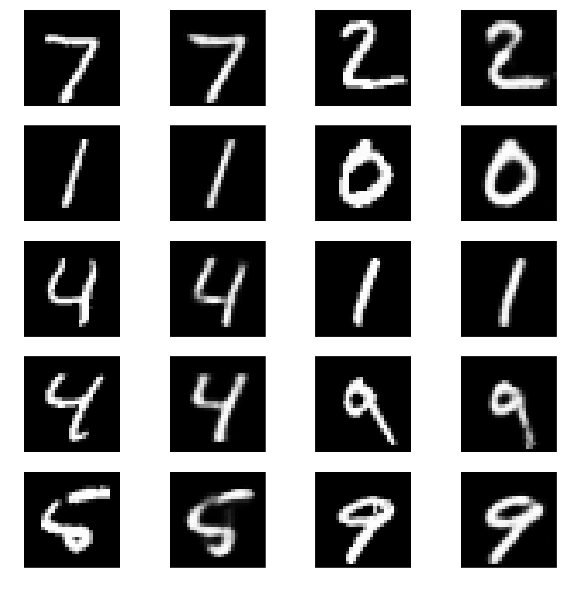

In [9]:
reconstructed = CVAE.reconstruct_data(test_batch_data, test_batch_labels)

plt.figure(figsize=[10,10])
index = 0
for i in range(0,20, 4):
    plt.subplot(5,4,i+1)
    plt.imshow(np.reshape(test_batch_data[index], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.subplot(5,4,i+2)
    plt.imshow(np.reshape(reconstructed[index], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.subplot(5,4,i+3)
    plt.imshow(np.reshape(test_batch_data[index+1], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.subplot(5,4,i+4)
    plt.imshow(np.reshape(reconstructed[index+1], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')
    index = index + 2

### Data Generation

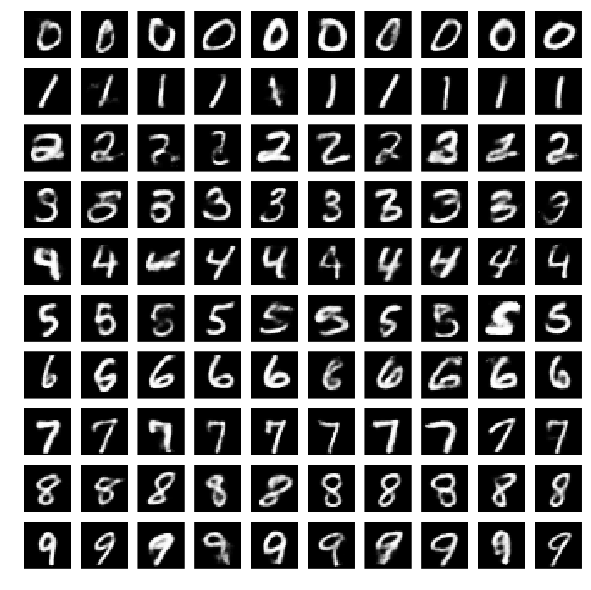

In [39]:
# Generate images per category
one_hot = np.repeat(np.eye(10),10, axis=0)
generated = CVAE.generate_data(one_hot, None)
plt.figure(figsize=[10,10])
for i in range(0,100):
    plt.subplot(10,10,i+1)
    plt.imshow(np.reshape(generated[i], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')